In [24]:
install.packages("jsonlite")
install.packages("gamlss")
library(gamlss)
require(gamlss)
require(ggplot2)

Installing package into '/home/eliasschreiner/R/x86_64-pc-linux-gnu-library/4.1'
(as 'lib' is unspecified)



Warning message in install.packages("jsonlite"):
"installation of package 'jsonlite' had non-zero exit status"
Installing package into '/home/eliasschreiner/R/x86_64-pc-linux-gnu-library/4.1'
(as 'lib' is unspecified)

Warning message in install.packages("gamlss"):
"installation of package 'gamlss' had non-zero exit status"
Loading required package: ggplot2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'ggplot2'"


In [2]:
### Does GAMLSS fullfill my assumptions: ?
###### distribution -> 10k_immu

###
whole_blood_healthy <- read.csv('whole_blood/whole_blood_combi_reduced.csv')
whole_blood_healthy_wo_meta <- read.csv('whole_blood/whole_blood_combi_reduced_wo_meta.csv')
# Set seed for reproducibility
set.seed(1337)
shuffled_data <- whole_blood_healthy[sample(nrow(whole_blood_healthy)), ]
split_index <- nrow(shuffled_data) / 2
train_data <- shuffled_data[1:split_index, ]
test_data <- shuffled_data[(split_index + 1):nrow(shuffled_data), ]
print(nrow(train_data))
print(nrow(test_data))
print(colnames(train_data))
## create a train test split at 50%


[1] 314
[1] 314
   [1] "X"                    "PLATFORM_GEO_ID"      "PLATFORM_DESCRIPTION"
   [4] "data_accession"       "subject_accession"    "age"                 
   [7] "gender"               "study_accession"      "DUSP22"              
  [10] "RPS28"                "IPO13"                "AFAP1"               
  [13] "CDT1"                 "TRPV1"                "LPP"                 
  [16] "CCNE2"                "HNRNPAB"              "SNIP1"               
  [19] "DIAPH2"               "HMG20B"               "CD69"                
  [22] "MLYCD"                "UHRF1BP1L"            "SERTAD2"             
  [25] "SPP1"                 "PCBD2"                "USP21"               
  [28] "RHD"                  "AUP1"                 "MFN2"                
  [31] "BRD9"                 "DCK"                  "ZFPM1"               
  [34] "KDM2B"                "ALOX5"                "MMP17"               
  [37] "GADD45G"              "ABCD4"                "FAM193A"          

In [3]:

### to model in gamells:
# technik:  marray RNAseq. 
# platform: hiseq, .... illumina...
# studie 
# age, sex
## 1 model: age
## 1 model: sex
## 1 model: age, sex
## dann das mit einzelnen korrektur variablen
#### platform, technik, studie.


# evtl qualität ??
# was halt sinn macht

### Distributional assumption
# why not found

### (platform +) site effects in all modes
### impute the mean -> dev strategy:
### generell: lieber leute als marker rauskicken (<10% missing value treshold, impute mean, >10%-100% remove marker).
# 50%> -> subject rmeoval   (when 1 subj got only halve the markers)

In [14]:

model <- gamlss(DUSP22 ~ age + gender + study_accession,
                sigma.formula = ~ age + gender + study_accession,
                data = train_data,
                family='NO') # models mean

## #TODO model variance too 
##### Should predictors for variance be the exact same in our case ? 
##### formula is just additive ?
######### ToSolve
##### Look at papers...
##### speak to thomas
## #TODO do this all for EVERY gene -> function + iteration


### Big picture: Bethlehem paper

summary(model)

GAMLSS-RS iteration 1: Global Deviance = 81.4194 
GAMLSS-RS iteration 2: Global Deviance = 80.175 
GAMLSS-RS iteration 3: Global Deviance = 80.1303 
GAMLSS-RS iteration 4: Global Deviance = 80.1222 
GAMLSS-RS iteration 5: Global Deviance = 80.1204 
GAMLSS-RS iteration 6: Global Deviance = 80.1199 
******************************************************************
Family:  c("NO", "Normal") 

Call:  gamlss(formula = DUSP22 ~ age + gender + study_accession,  
    sigma.formula = ~age + gender + study_accession,  
    family = "NO", data = train_data) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             3.2448713  0.1753488  18.505  < 2e-16 ***
age                     0.0010398  0.0007256   1.433    0.153    
gendermale              0.0068724  0.0281316   0.244    0.807    
study_accessionSDY111   4.0965229  0.1762435

In [30]:
# Generate some sample data for plotting
new_data <- expand.grid(age = seq(0, 90, length.out = 100),
                        gender = unique(test_data$gender),
                        study_accession = unique(test_data$study_accession))

# Predict the values using the GAMLSS model
#predictions <- predict(model, newdata = new_data, type = "response")
preds_mu <- predict(model, newdata = new_data, what = "mu")
preds_sigma <- predict(model, newdata = new_data, what = "sigma")


Warning message:
"The following aesthetics were dropped during statistical transformation: xmin
and xmax.
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"


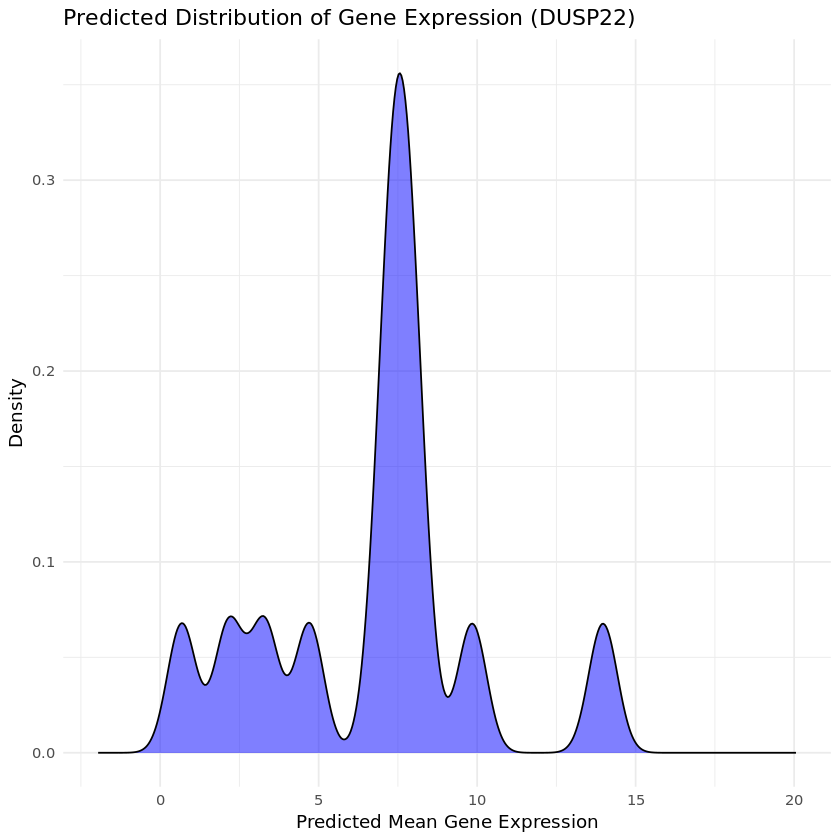

In [49]:
plot_data <- data.frame(
  mean = preds_mu,
  lower = preds_mu - 1.96 * preds_sigma,
  upper = preds_mu + 1.96 * preds_sigma
)

ggplot(data = plot_data, aes(x = mean)) +
  geom_density(fill = "blue", alpha = 0.5) +
  geom_ribbon(aes(ymin = after_stat(density), ymax =after_stat(density), xmin = lower, xmax = upper), 
              stat = "density", fill = "orange", alpha = 0.2) +
  labs(title = "Predicted Distribution of Gene Expression (DUSP22)",
       x = "Predicted Mean Gene Expression",
       y = "Density") +
  theme_minimal()
  

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


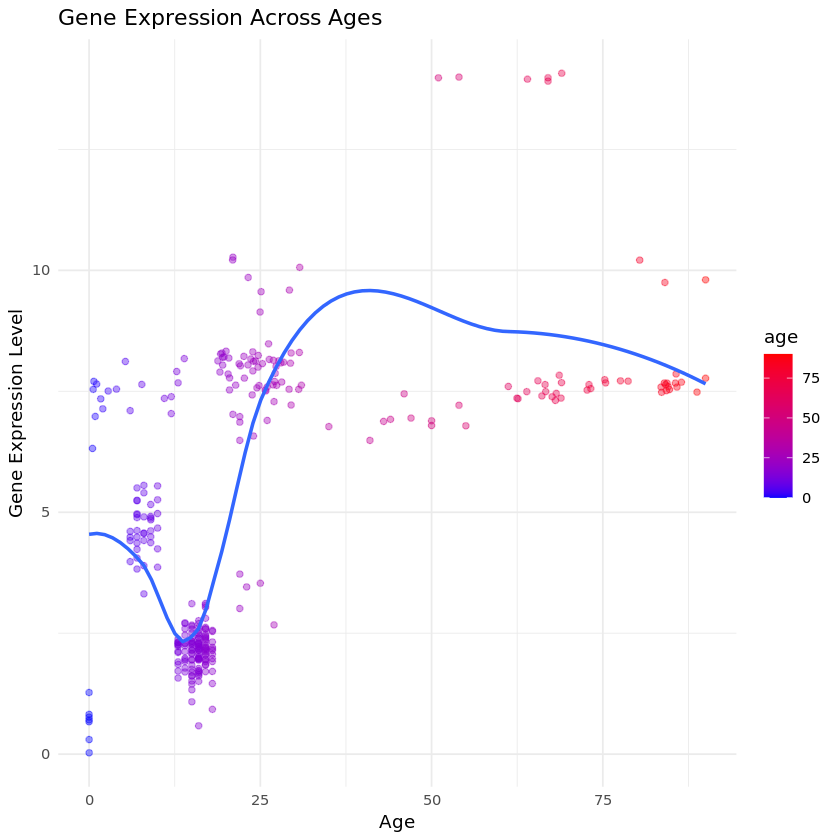

In [54]:
ggplot(train_data, aes(x = age, y = DUSP22)) +
  geom_point(aes(color = age), alpha = 0.4) +
  geom_smooth(se = FALSE) +  # Add a smoothing line without the confidence interval
  scale_color_gradient(low = "blue", high = "red") +
  labs(title = "Gene Expression Across Ages",
       x = "Age",
       y = "Gene Expression Level") +
  theme_minimal()